<a href="https://colab.research.google.com/github/cam2149/DistributedProcessing/blob/main/3_Procesamiento_en_paralelo_con_dask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Instalación de librerias necesarias**

In [35]:
!wc -l universal_top_spotify_songs.csv

2110317 universal_top_spotify_songs.csv


In [36]:
!pip install dask[complete] pandas numpy matplotlib kaggle

In [37]:
!du -hs *

4.0K	dask-expr.svg
55M	sample_data
162M	top-spotify-songs-in-73-countries-daily-updated.zip
475M	universal_top_spotify_songs.csv


###**Configuración  de Kaggle**

In [38]:
# Crear la carpeta oculta .kaggle en tu home, allí se guardará el archivo JSON
!mkdir -p ~/.kaggle

# Mover el archivo kaggle.json a esa carpeta
!mv kaggle.json ~/.kaggle/

# cambia los permisos de acceso, solo al usuario actual
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


In [39]:
! kaggle datasets download "asaniczka/top-spotify-songs-in-73-countries-daily-updated" --force

Dataset URL: https://www.kaggle.com/datasets/asaniczka/top-spotify-songs-in-73-countries-daily-updated
License(s): ODC Attribution License (ODC-By)
 75% 122M/162M [00:00<00:00, 318MB/s] 
100% 162M/162M [00:00<00:00, 359MB/s]


In [40]:
!unzip top-spotify-songs-in-73-countries-daily-updated.zip

Archive:  top-spotify-songs-in-73-countries-daily-updated.zip
replace universal_top_spotify_songs.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: universal_top_spotify_songs.csv  


###**A continuación se importaran las librerias requeridas para el laboratorio**

In [41]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import time

In [42]:
df_pandas = pd.read_csv('/content/universal_top_spotify_songs.csv')

In [43]:
df_pandas.describe()

,daily_rank,daily_movement,weekly_movement,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,2.110316e+06,2.110316e+06,2.110316e+06,2.110316e+06,2.110316e+06,2.110316e+06,2.110316e+06,2.110316e+06,2.110316e+06,2.110316e+06,2.110316e+06,2.110316e+06,2.110316e+06,2.110316e+06,2.110316e+06,2.110316e+06,2.110316e+06
mean,2.549302e+01,9.230660e-01,2.932522e+00,7.590713e+01,1.943095e+05,6.759191e-01,6.488031e-01,5.526496e+00,-6.772439e+00,5.364571e-01,9.550408e-02,2.748491e-01,2.316185e-02,1.705588e-01,5.462535e-01,1.221008e+02,3.900368e+00
std,1.442900e+01,7.015535e+00,1.233129e+01,1.576302e+01,4.986054e+04,1.440469e-01,1.689142e-01,3.594979e+00,3.874849e+00,4.986692e-01,9.138830e-02,2.509297e-01,1.137297e-01,1.247528e-01,2.311527e-01,2.781938e+01,4.044448e-01
min,1.000000e+00,-4.900000e+01,-4.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.010000e-05,0.000000e+00,-5.434100e+01,0.000000e+00,0.000000e+00,3.450000e-06,0.000000e+00,1.390000e-02,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.300000e+01,-1.000000e+00,-3.000000e+00,6.500000e+01,1.626370e+05,5.800000e-01,5.520000e-01,2.000000e+00,-7.830000e+00,0.000000e+00,3.840000e-02,6.670000e-02,0.000000e+00,9.610000e-02,3.700000e-01,1.000190e+02,4.000000e+00
50%,2.500000e+01,0.000000e+00,0.000000e+00,7.900000e+01,1.861910e+05,7.000000e-01,6.680000e-01,6.000000e+00,-6.064000e+00,1.000000e+00,5.810000e-02,1.910000e-01,1.340000e-06,1.220000e-01,5.480000e-01,1.199650e+02,4.000000e+00
75%,3.800000e+01,2.000000e+00,5.000000e+00,8.800000e+01,2.187010e+05,7.800000e-01,7.670000e-01,9.000000e+00,-4.723000e+00,1.000000e+00,1.120000e-01,4.370000e-01,1.010000e-04,2.040000e-01,7.330000e-01,1.400210e+02,4.000000e+00
max,5.000000e+01,4.900000e+01,4.900000e+01,1.000000e+02,1.296000e+06,9.880000e-01,9.980000e-01,1.100000e+01,3.233000e+00,1.000000e+00,9.570000e-01,9.960000e-01,9.950000e-01,9.830000e-01,9.920000e-01,2.360890e+02,5.000000e+00


In [44]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2110316 entries, 0 to 2110315
Data columns (total 25 columns):
 #   Column              Dtype  
---  ------              -----  
 0   spotify_id          object 
 1   name                object 
 2   artists             object 
 3   daily_rank          int64  
 4   daily_movement      int64  
 5   weekly_movement     int64  
 6   country             object 
 7   snapshot_date       object 
 8   popularity          int64  
 9   is_explicit         bool   
 10  duration_ms         int64  
 11  album_name          object 
 12  album_release_date  object 
 13  danceability        float64
 14  energy              float64
 15  key                 int64  
 16  loudness            float64
 17  mode                int64  
 18  speechiness         float64
 19  acousticness        float64
 20  instrumentalness    float64
 21  liveness            float64
 22  valence             float64
 23  tempo               float64
 24  time_signature      int6

###**Configuración de dask en modo de procesos**

###**Lectura de datos con pandas y dask**

In [45]:

dd_df = dd.read_csv('universal_top_spotify_songs.csv',dtype={'country': 'object'},sep=',')

###**Operaciones con Dask**

In [46]:
operation = dd_df.select_dtypes(include=['float64']).mean().compute(scheduler='processes')
operation = dd_df[dd_df['daily_rank'] > 0.5].compute()
dd_df['first_rank'] =  dd_df.map_partitions( lambda df:
                                            df.apply(
                                                lambda x:True if x['daily_rank'] == 1 else False, axis=1)).compute(
                                                    )


In [48]:
print(dd_df.npartitions)

7


In [49]:
dd_df = dd_df.repartition(npartitions=3)

In [50]:
print(dd_df.npartitions)

3


In [51]:
dd_df

,spotify_id,name,artists,daily_rank,daily_movement,weekly_movement,country,snapshot_date,popularity,is_explicit,duration_ms,album_name,album_release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,first_rank
npartitions=3,,,,,,,,,,,,,,,,,,,,,,,,,,
,string,string,string,int64,int64,int64,string,string,int64,bool,int64,string,string,float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,float64,int64,bool
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [52]:
dd_df.info()

<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 26 entries, spotify_id to first_rank
dtypes: bool(2), float64(9), int64(8), string(7)

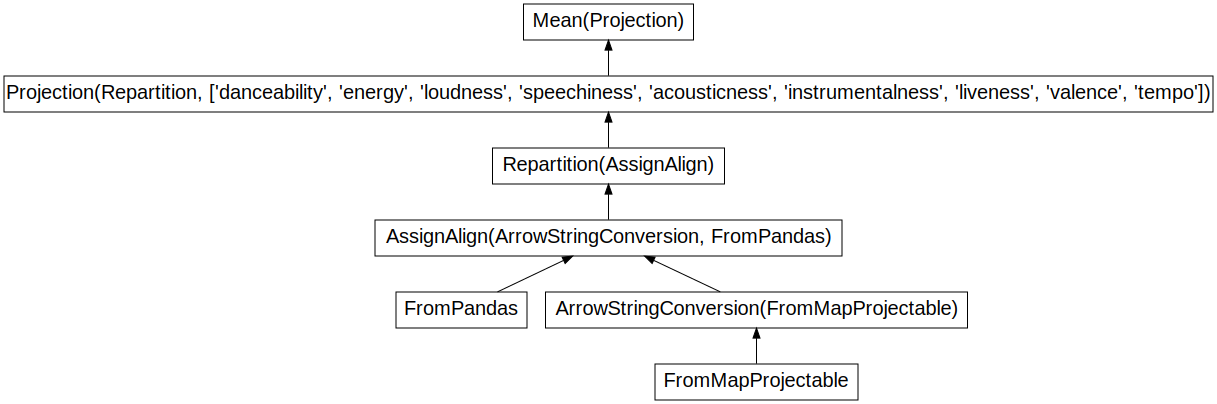

In [53]:
dd_df.select_dtypes(include=['float64']).mean().visualize()

In [54]:

dd_df = dd.read_csv('universal_top_spotify_songs.csv',dtype={'country': 'object'},sep=',')
# Reparticionar dataframe
dd_df = dd_df.repartition(npartitions=3)
dd_df.get_partition(0).head(1).to_dict()

{'spotify_id': {0: '2RkZ5LkEzeHGRsmDqKwmaJ'},
 'name': {0: 'Ordinary'},
 'artists': {0: 'Alex Warren'},
 'daily_rank': {0: 1},
 'daily_movement': {0: 1},
 'weekly_movement': {0: 0},
 'country': {0: None},
 'snapshot_date': {0: '2025-06-11'},
 'popularity': {0: 95},
 'is_explicit': {0: False},
 'duration_ms': {0: 186964},
 'album_name': {0: "You'll Be Alright, Kid (Chapter 1)"},
 'album_release_date': {0: '2024-09-26'},
 'danceability': {0: 0.368},
 'energy': {0: 0.694},
 'key': {0: 2},
 'loudness': {0: -6.141},
 'mode': {0: 1},
 'speechiness': {0: 0.06},
 'acousticness': {0: 0.704},
 'instrumentalness': {0: 6.59e-06},
 'liveness': {0: 0.055},
 'valence': {0: 0.391},
 'tempo': {0: 168.115},
 'time_signature': {0: 3}}

In [55]:
dd_df.get_partition(0).describe().compute()

,daily_rank,daily_movement,weekly_movement,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,604799.000000,604799.000000,604799.000000,604799.000000,6.047990e+05,604799.000000,604799.000000,604799.000000,604799.000000,604799.000000,604799.000000,604799.000000,604799.000000,604799.000000,604799.000000,604799.000000,604799.000000
mean,25.495057,0.910000,3.244924,74.864181,1.991155e+05,0.655959,0.638183,5.500690,-7.621491,0.534574,0.097566,0.283641,0.037739,0.171492,0.531216,121.699214,3.888034
std,14.429401,7.007651,12.744339,15.810560,5.048942e+04,0.157524,0.183934,3.637058,5.894927,0.498804,0.094715,0.255589,0.154476,0.125402,0.239688,27.078405,0.420167
min,1.000000,-45.000000,-49.000000,0.000000,0.000000e+00,0.093900,0.001740,0.000000,-54.341000,0.000000,0.023000,0.000005,0.000000,0.019100,0.000010,36.648000,1.000000
25%,13.000000,-2.000000,-3.000000,64.000000,1.668800e+05,0.556000,0.549000,2.000000,-8.130000,0.000000,0.037500,0.068800,0.000000,0.096900,0.355000,101.000000,4.000000
50%,25.000000,0.000000,0.000000,78.000000,1.895240e+05,0.687000,0.661000,6.000000,-6.203000,1.000000,0.058500,0.204000,0.000002,0.124000,0.535000,119.973000,4.000000
75%,38.000000,2.000000,6.000000,87.000000,2.240220e+05,0.772000,0.772000,9.000000,-4.836000,1.000000,0.118000,0.446000,0.000207,0.202000,0.721000,138.953000,4.000000
max,50.000000,49.000000,49.000000,100.000000,1.296000e+06,0.975000,0.996000,11.000000,2.194000,1.000000,0.957000,0.996000,0.995000,0.983000,0.992000,236.089000,5.000000


In [ ]:
dd_df.get_partition(2).describe().compute()

In [56]:
dd_df['snapshot_date'].value_counts().compute()

,count
snapshot_date,
2023-10-26,3644
2023-11-01,3641
2023-11-07,3641
2023-11-09,3644
2023-11-13,3583
...,...
2025-05-30,3600
2025-06-01,3600
2025-06-08,3600


In [57]:
dd_df =  dd_df[dd_df['snapshot_date'] == '2025-06-01']
dd_df['duration_sec'] =  dd_df['duration_ms']/100
dd_df = dd_df.sort_values(by='album_release_date',ascending=False)


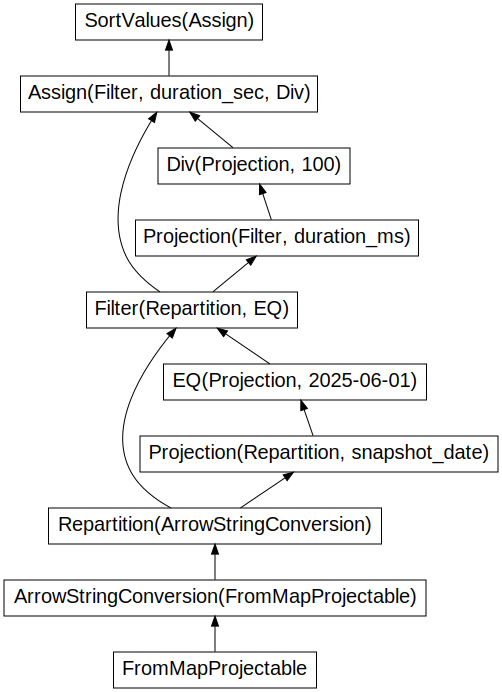

In [58]:
dd_df.visualize()

In [59]:
dd_df.compute(scheduler="threads")

,spotify_id,name,artists,daily_rank,daily_movement,weekly_movement,country,snapshot_date,popularity,is_explicit,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_sec
36024,2yWlGEgEfPot0lv3OAjuG3,Just Keep Watching (From F1® The Movie),"Tate McRae, F1 The Album",25,-16,25,<NA>,2025-06-01,77,False,...,-5.856,0,0.1130,0.0767,0.000000,0.5090,0.425,129.956,4,1425.50
36062,3fD3CRxrTurrH3W4nJEt26,Ndonwabile (feat. Raspy & Babalwa M),"Kelvin Momo, Raspy, Babalwa M",13,-7,37,ZA,2025-06-01,52,False,...,-12.225,0,0.0530,0.0262,0.034700,0.0427,0.323,111.997,4,3810.96
36063,0OMHMgH263gIrUcszYYivV,Emhlabeni (feat. Thatohatsi & Tracy),"Kelvin Momo, Da Muziqal Chef, Thatohatsi, Tracy",14,-9,36,ZA,2025-06-01,54,False,...,-12.271,0,0.0588,0.0107,0.047300,0.1130,0.708,112.007,4,5185.96
36065,2MSzTLwjCFUcGrxNFvU6pm,Mkhuzeni (feat. Da Muziqal Chef),"Kelvin Momo, Babalwa M, Da Muziqal Chef",16,-4,34,ZA,2025-06-01,51,False,...,-8.973,0,0.0531,0.0152,0.044400,0.0345,0.543,113.015,4,5274.95
36066,1mNdXonMhTsnQd95Oo5SED,Buya,"Kelvin Momo, Yallunder",17,-13,33,ZA,2025-06-01,54,False,...,-16.970,1,0.0451,0.7410,0.000704,0.3780,0.117,112.592,4,3841.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37161,0ofHAoxe9vBkTCp2UQIavz,Dreams - 2004 Remaster,Fleetwood Mac,12,2,1,NZ,2025-06-01,90,False,...,-9.744,1,0.0276,0.0644,0.004280,0.1280,0.789,120.151,4,2578.00
38084,0ofHAoxe9vBkTCp2UQIavz,Dreams - 2004 Remaster,Fleetwood Mac,35,1,-2,IE,2025-06-01,90,False,...,-9.744,1,0.0276,0.0644,0.004280,0.1280,0.789,120.151,4,2578.00
39138,0ofHAoxe9vBkTCp2UQIavz,Dreams - 2004 Remaster,Fleetwood Mac,39,8,3,CA,2025-06-01,90,False,...,-9.744,1,0.0276,0.0644,0.004280,0.1280,0.789,120.151,4,2578.00
39428,0ofHAoxe9vBkTCp2UQIavz,Dreams - 2004 Remaster,Fleetwood Mac,29,0,5,AU,2025-06-01,90,False,...,-9.744,1,0.0276,0.0644,0.004280,0.1280,0.789,120.151,4,2578.00


In [60]:
dd_df.compute(scheduler="processes")

,spotify_id,name,artists,daily_rank,daily_movement,weekly_movement,country,snapshot_date,popularity,is_explicit,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_sec
36024,2yWlGEgEfPot0lv3OAjuG3,Just Keep Watching (From F1® The Movie),"Tate McRae, F1 The Album",25,-16,25,<NA>,2025-06-01,77,False,...,-5.856,0,0.1130,0.0767,0.000000,0.5090,0.425,129.956,4,1425.50
36062,3fD3CRxrTurrH3W4nJEt26,Ndonwabile (feat. Raspy & Babalwa M),"Kelvin Momo, Raspy, Babalwa M",13,-7,37,ZA,2025-06-01,52,False,...,-12.225,0,0.0530,0.0262,0.034700,0.0427,0.323,111.997,4,3810.96
36063,0OMHMgH263gIrUcszYYivV,Emhlabeni (feat. Thatohatsi & Tracy),"Kelvin Momo, Da Muziqal Chef, Thatohatsi, Tracy",14,-9,36,ZA,2025-06-01,54,False,...,-12.271,0,0.0588,0.0107,0.047300,0.1130,0.708,112.007,4,5185.96
36065,2MSzTLwjCFUcGrxNFvU6pm,Mkhuzeni (feat. Da Muziqal Chef),"Kelvin Momo, Babalwa M, Da Muziqal Chef",16,-4,34,ZA,2025-06-01,51,False,...,-8.973,0,0.0531,0.0152,0.044400,0.0345,0.543,113.015,4,5274.95
36066,1mNdXonMhTsnQd95Oo5SED,Buya,"Kelvin Momo, Yallunder",17,-13,33,ZA,2025-06-01,54,False,...,-16.970,1,0.0451,0.7410,0.000704,0.3780,0.117,112.592,4,3841.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37161,0ofHAoxe9vBkTCp2UQIavz,Dreams - 2004 Remaster,Fleetwood Mac,12,2,1,NZ,2025-06-01,90,False,...,-9.744,1,0.0276,0.0644,0.004280,0.1280,0.789,120.151,4,2578.00
38084,0ofHAoxe9vBkTCp2UQIavz,Dreams - 2004 Remaster,Fleetwood Mac,35,1,-2,IE,2025-06-01,90,False,...,-9.744,1,0.0276,0.0644,0.004280,0.1280,0.789,120.151,4,2578.00
39138,0ofHAoxe9vBkTCp2UQIavz,Dreams - 2004 Remaster,Fleetwood Mac,39,8,3,CA,2025-06-01,90,False,...,-9.744,1,0.0276,0.0644,0.004280,0.1280,0.789,120.151,4,2578.00
39428,0ofHAoxe9vBkTCp2UQIavz,Dreams - 2004 Remaster,Fleetwood Mac,29,0,5,AU,2025-06-01,90,False,...,-9.744,1,0.0276,0.0644,0.004280,0.1280,0.789,120.151,4,2578.00


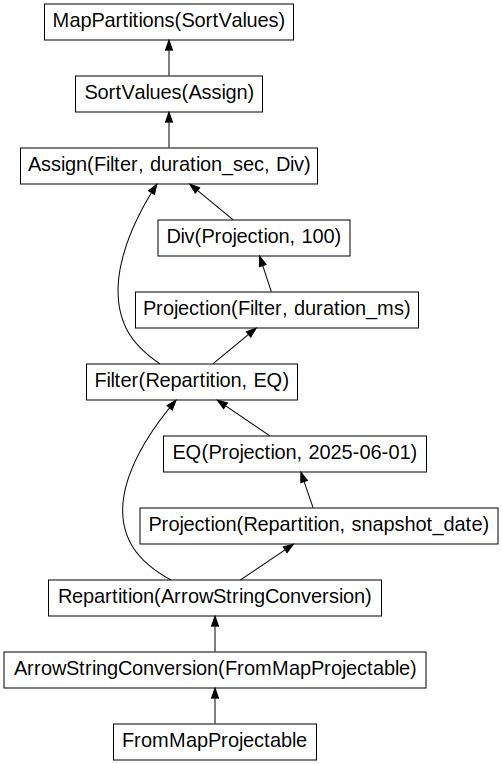

In [61]:
dd_df.map_partitions( lambda df:
                                            df.apply(
                                                lambda x:True if x['daily_rank'] == 1 else False, axis=1)).visualize()

In [69]:
n_rows = 1000000
n_cols = 5
data = np.random.rand(n_rows, n_cols) # Assign data here, for example, a numpy array
df_pandas = pd.DataFrame(data, columns=[f'col_{i}' for i in range(n_cols)])
df_dask = dd.from_pandas( df_pandas, npartitions=10)
start = time.time()
mean_pandas = df_pandas.mean()
end = time.time()
print("Tiempo con Pandas:", end - start, "segundos")
start = time.time()
mean_dask = df_dask.mean().compute()  # Se requiere `compute()`
end = time.time()
print("Tiempo con Dask:", end - start, "segundos")

Tiempo con Pandas: 0.07927227020263672 segundos
Tiempo con Dask: 0.22222161293029785 segundos


In [63]:
df_pandas.memory_usage()

,0
Index,132
spotify_id,16882528
name,16882528
artists,16882528
daily_rank,16882528
daily_movement,16882528
weekly_movement,16882528
country,16882528
snapshot_date,16882528
popularity,16882528


In [64]:
%whos

Variable    Type         Data/Info
----------------------------------
dd          module       <module 'dask.dataframe' <...>k/dataframe/__init__.py'>
dd_df       DataFrame    Dask DataFrame Structure:<...>ending=False, options={})
df_pandas   DataFrame                         spot<...>110316 rows x 25 columns]
np          module       <module 'numpy' from '/us<...>kages/numpy/__init__.py'>
operation   Series       danceability          0.6<...>22.100752\ndtype: float64
pd          module       <module 'pandas' from '/u<...>ages/pandas/__init__.py'>
time        module       <module 'time' (built-in)>


In [ ]:
#Generar grafo de daily_movement	weekly_movement, un proceso en dask que multiple las columnas daily_movement
#weekly_movement y al final genere el promedio general sobre la nueva columna creada.
#Al final tomar la diferencia entre dask y pandas y explicar el grafo

In [70]:
lab_dd = dd.read_csv('universal_top_spotify_songs.csv',dtype={'country': 'object'},sep=',')

In [67]:
lab_dd['top_10'] = lab_dd.map_partitions( lambda df:
                                            df.apply(
                                                lambda x:True if x['daily_rank'] <= 10 else False, axis=1))

In [68]:
lab_df =  lab_dd.compute(scheduler='processes')

In [71]:
lab_df[['daily_rank','top_10']]

,daily_rank,top_10
0,1,True
1,2,True
2,3,True
3,4,True
4,5,True
...,...,...
299290,46,False
299291,47,False
299292,48,False
299293,49,False


**Taller en clase**

Descargar yellow tripdata de enero, febrero, marzo de 2025. Link  https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page



1.   Llenar los valores nulos de la columna passenger count con 0
2.   Agregar los datos por vendorId sumando la cantidad de pasajeros totales  y el promedio de fare amount

3.  Crear una variable sintetica que indique si el viaje tuvo propina
4.  Calcular los precio promedio por minutos



